# 1 Import Library

In [1]:
%reset -f

In [2]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/DAS/Run3/wrk/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate
import sys
sys.path.append("../")
import plotting
from pyseis.wave_equations import elastic_isotropic
from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

# 2 Read Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dir_model = "../Data/"

n_traces, n_samples = 883, 5000
use_samples = 3000
dtype = np.float32  # change if needed

# Load full then trim
data1 = np.fromfile(dir_model+"stack.run3.decon.geo_ch15_median.bin", dtype=dtype)\
            .reshape(n_traces, n_samples)[:, :use_samples]

print("data1 shape:", data1.shape)


data1 shape: (883, 3000)


data1 shape: (883, 2000)


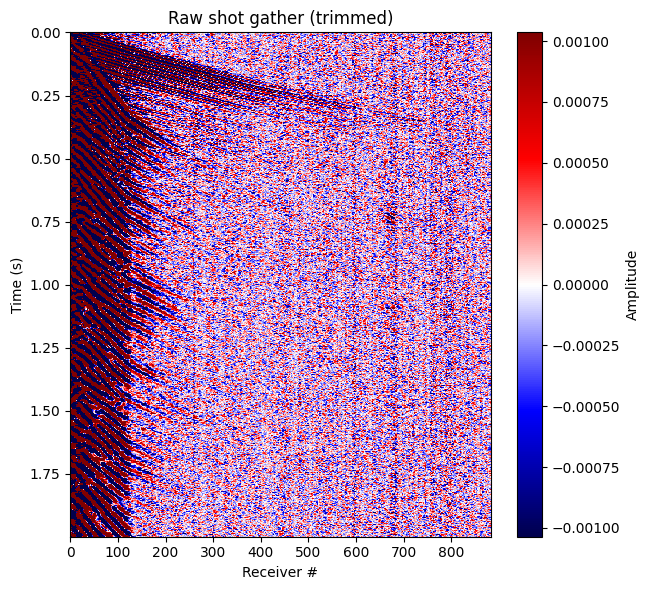

In [5]:
# STEP 1 — Load & show RAW (trimmed) shot gather
import numpy as np
import matplotlib.pyplot as plt

# ---- params ----
dir_model   = "../Data/"
fname       = "stack.run3.decon.geo_ch15_median.bin"
n_traces    = 883
n_samples   = 5000
use_samples = 2000
dtype       = np.float32
dt          = 0.001  # s

# ---- load & trim ----
data1 = np.fromfile(dir_model + fname, dtype=dtype).reshape(n_traces, n_samples)[:, :use_samples]
print("data1 shape:", data1.shape)  # should be (883, 3000)

# ---- plot ----
vmax = np.percentile(np.abs(data1), 85)  # robust clip
t = np.arange(use_samples) * dt
r = np.arange(n_traces)

plt.figure(figsize=(6.6, 6))
plt.pcolormesh(r, t, data1.T, shading="nearest", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.gca().invert_yaxis()
plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title("Raw shot gather (trimmed)")
plt.tight_layout()
plt.show()


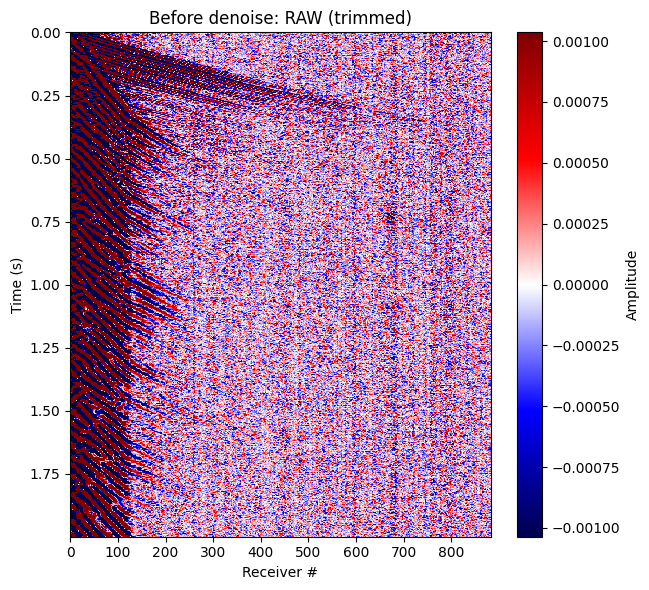

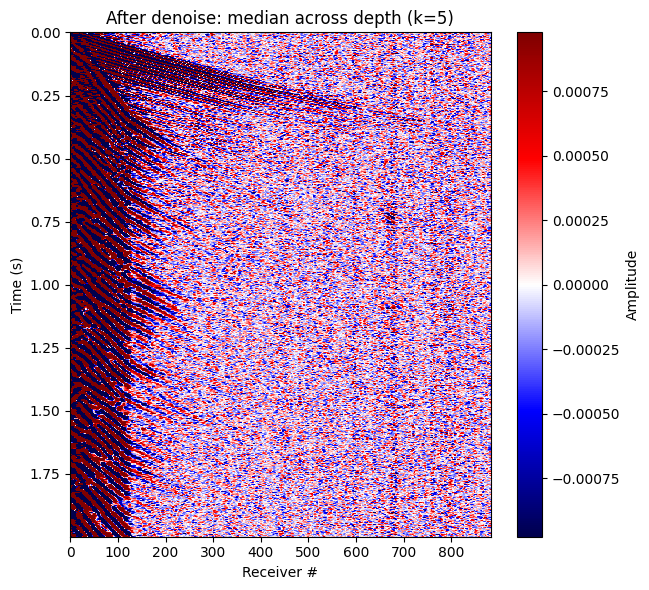

In [6]:
# D1 — DAS instrument denoise: small median across depth (channels)

import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

# input = RAW trimmed gather from Step 1
G_in = data1                  # shape: (nr, nt)
k_depth = 5                   # odd; try 5–7. Keep SMALL to avoid smearing dips.

# median along depth (axis=0), window k_depth
if k_depth % 2 == 0: k_depth += 1
pad = k_depth // 2
Gp = np.pad(G_in, ((pad, pad), (0, 0)), mode="edge")            # pad in depth
W  = sliding_window_view(Gp, window_shape=(k_depth, Gp.shape[1]))  # (nr, 1, k, nt)
W  = W[:, 0, :, :]                                              # (nr, k, nt)
data1_dn = np.median(W, axis=1).astype(G_in.dtype, copy=False)  # (nr, nt)

# QC plots
def show(G, title, dt=0.001):
    nr, nt = G.shape
    r = np.arange(nr); t = np.arange(nt)*dt
    vmax = np.percentile(np.abs(G), 85)
    plt.figure(figsize=(6.6,6))
    plt.pcolormesh(r, t, G.T, shading='nearest', cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.gca().invert_yaxis(); plt.colorbar(label='Amplitude')
    plt.xlabel('Receiver #'); plt.ylabel('Time (s)'); plt.title(title)
    plt.tight_layout(); plt.show()

show(G_in,     "Before denoise: RAW (trimmed)")
show(data1_dn, f"After denoise: median across depth (k={k_depth})")


band-limited shape: (883, 2000)


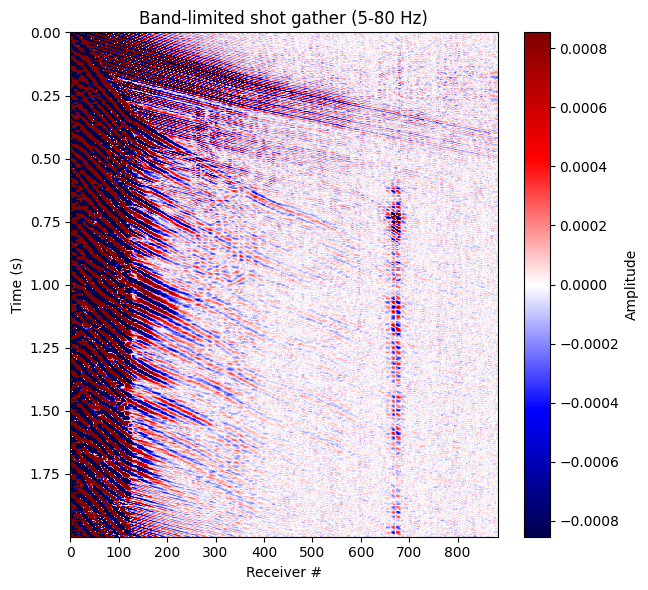

In [7]:
# STEP 2 — Band-limit the gather (e.g., 5–80 Hz) and display

import numpy as np
import matplotlib.pyplot as plt

# ---- params ----
fmin, fmax = 5.0, 80.0   # Hz
dt = 0.001               # s (must match Step 1)

# ---- band-pass via FFT (NumPy only) ----
def bandpass_fft(G, dt, fmin, fmax):
    nr, nt = G.shape
    F = np.fft.rfftfreq(nt, d=dt)           # positive freqs
    mask = (F >= fmin) & (F <= fmax)        # passband mask
    Gf = np.fft.rfft(G, axis=1)
    Gf *= mask[None, :]
    return np.fft.irfft(Gf, n=nt, axis=1)

data_bp = bandpass_fft(data1_dn, dt, fmin, fmax)
print("band-limited shape:", data_bp.shape)

# ---- plot ----
vmax = np.percentile(np.abs(data_bp), 85)
t = np.arange(data_bp.shape[1]) * dt
r = np.arange(data_bp.shape[0])

plt.figure(figsize=(6.6, 6))
plt.pcolormesh(r, t, data_bp.T, shading="nearest", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.gca().invert_yaxis()
plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title(f"Band-limited shot gather ({fmin:.0f}-{fmax:.0f} Hz)")
plt.tight_layout()
plt.show()


In [8]:
# STEP 3
## Step 3.0 load the first picks
import pandas as pd
import numpy as np

dt = 0.001  # must match your gather

fp = pd.read_csv("real_first_picks.csv", header=None, names=["trace","time"])
real_trace = fp["trace"].to_numpy(int) - 1     # 1-based → 0-based indices
real_time  = fp["time"].to_numpy(float)

# convert times to sample indices
fb_use = (real_time / dt).astype(int)

print("picks:", fb_use.shape, "min/max samples:", fb_use.min(), fb_use.max())


picks: (883,) min/max samples: 0 408


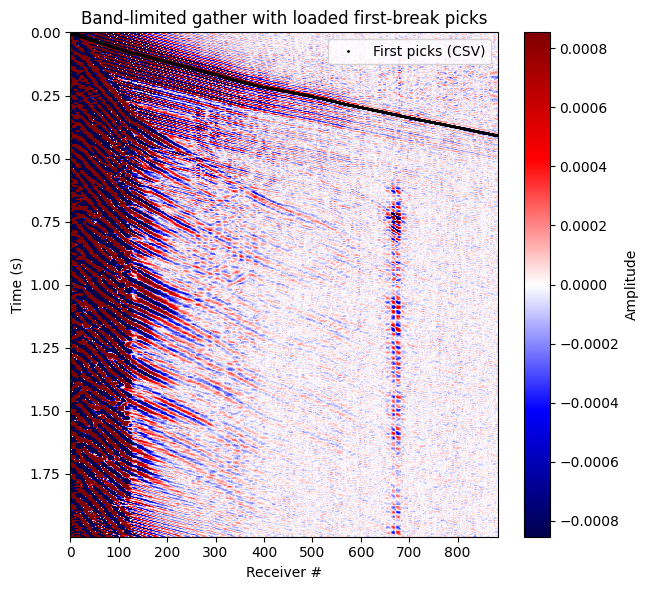

In [9]:
## Step 3.1: QC: overlay picks on the band-limited gather


import matplotlib.pyplot as plt

nr, nt = data_bp.shape
t = np.arange(nt) * dt
r = np.arange(nr)

vmax = np.percentile(np.abs(data_bp), 85)
plt.figure(figsize=(6.6,6))
plt.pcolormesh(r, t, data_bp.T, shading="nearest", cmap="seismic",
               vmin=-vmax, vmax=vmax)
plt.plot(real_trace, real_time, "k.", ms=2, label="First picks (CSV)")
plt.gca().invert_yaxis()
plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title("Band-limited gather with loaded first-break picks")
plt.legend(); plt.tight_layout(); plt.show()


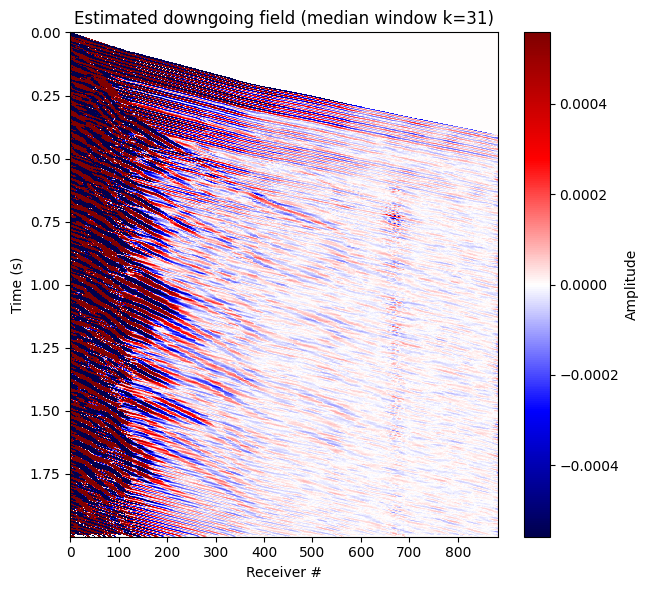

In [10]:
# STEP 3.2 — Align by first breaks → estimate downgoing (corridor-style median) → unalign → plot

import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

# ---------- params ----------
k_median = 31   # depth median window (must be odd). Try 21–41 if needed.

# ---------- helpers ----------
def align_by_fb(G, fb):
    """Shift each trace earlier so first break aligns at t=0."""
    nr, nt = G.shape
    out = np.zeros_like(G)
    for i in range(nr):
        s = int(fb[i])
        if 0 <= s < nt:
            out[i, :nt-s] = G[i, s:]
    return out

def unalign_by_fb(Ga, fb):
    """Undo alignment to original timing."""
    nr, nt = Ga.shape
    out = np.zeros_like(Ga)
    for i in range(nr):
        s = int(fb[i])
        if 0 <= s < nt:
            out[i, s:] = Ga[i, :nt-s]
    return out

def depth_running_median(Ga, k=31):
    """
    Median along depth (axis=0) with window k.
    Returns array with same shape as Ga: (nr, nt).
    """
    if k % 2 == 0:
        k += 1
    pad = k // 2
    # pad along depth only
    Gp = np.pad(Ga, ((pad, pad), (0, 0)), mode="edge")   # (nr+2*pad, nt)
    # sliding windows across depth spanning full time axis -> (nr, k, nt)
    W = sliding_window_view(Gp, window_shape=(k, Gp.shape[1]))
    W = W[:, 0, :, :]
    # median across the depth window
    return np.median(W, axis=1)

# ---------- compute ----------
aligned            = align_by_fb(data_bp, fb_use)
down_est_aligned   = depth_running_median(aligned, k=k_median)
down_est           = unalign_by_fb(down_est_aligned, fb_use)

# ---------- plot ----------
nr, nt = down_est.shape
t = np.arange(nt) * dt
r = np.arange(nr)
vmax = np.percentile(np.abs(down_est), 85)

plt.figure(figsize=(6.6, 6))
plt.pcolormesh(r, t, down_est.T, shading="nearest", cmap="seismic",
               vmin=-vmax, vmax=vmax)
plt.gca().invert_yaxis()
plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title(f"Estimated downgoing field (median window k={k_median})")
plt.tight_layout(); plt.show()


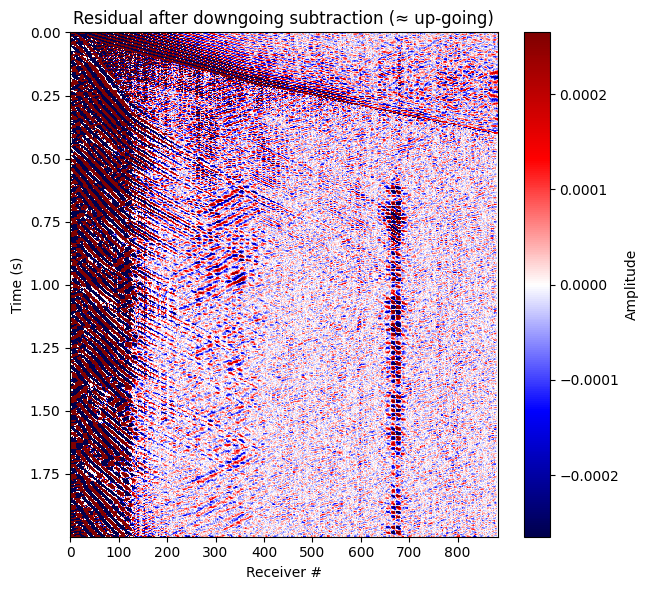

In [11]:
# STEP 3.3 — Subtract downgoing estimate → get up-going residual, then plot

import numpy as np
import matplotlib.pyplot as plt

# Inputs assumed from prior steps:
# data_bp : band-limited gather, shape (nr, nt)
# down_est: estimated downgoing field from Step 3.2, shape (nr, nt)
# dt      : sample interval (s)

# --- subtraction ---
upgoing_0 = data_bp - down_est     # residual ≈ up-going reflections

# --- plot ---
nr, nt = upgoing_0.shape
r = np.arange(nr)
t = np.arange(nt) * dt
vmax = np.percentile(np.abs(upgoing_0), 85)  # robust clip

plt.figure(figsize=(6.6, 6))
plt.pcolormesh(r, t, upgoing_0.T, shading="nearest", cmap="seismic",
               vmin=-vmax, vmax=vmax)
plt.gca().invert_yaxis()
plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title("Residual after downgoing subtraction (≈ up-going)")
plt.tight_layout(); plt.show()

# (optional) keep for next step (f–k fan mute)
# upgoing_input = upgoing_0.copy()



In [12]:
# STEP 4.0 — setup for f–k mute (dz fixed to 1 m)

import numpy as np, matplotlib.pyplot as plt

G  = upgoing_0         # from Step 3.3
dt = 0.001             # s
dz = 1.0               # m  ← your DAS channel spacing


nr, nt = G.shape
t = np.arange(nt) * dt
r = np.arange(nr)
print("Gather:", nr, "traces ×", nt, "samples; dz =", dz, "m")



Gather: 883 traces × 2000 samples; dz = 1.0 m


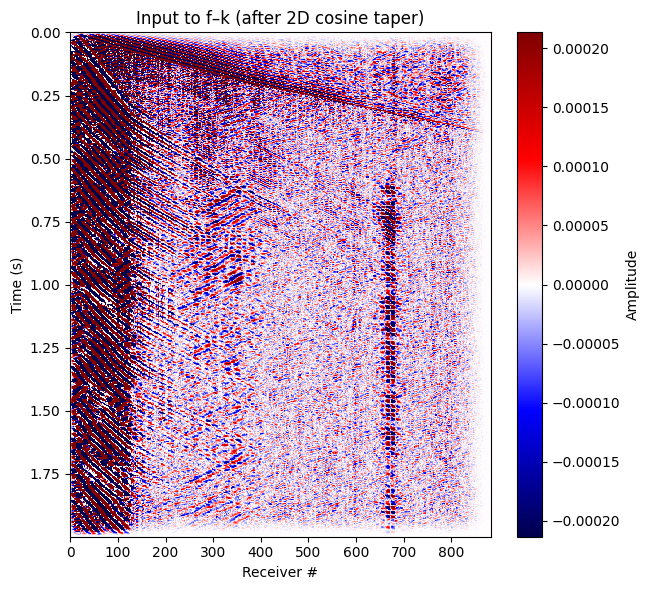

In [13]:
# STEP 4.1 — apply depth/time tapers for FFT

def cosine_taper(n, p=0.1):
    p = max(0.0, min(0.5, p))
    m = int(p*n); w = np.ones(n)
    if m > 0:
        ramp = 0.5*(1 - np.cos(np.pi*np.arange(m)/m))
        w[:m] = ramp; w[-m:] = ramp[::-1]
    return w

wz = cosine_taper(nr, 0.10)[:, None]  # 10% depth taper
wt = cosine_taper(nt, 0.05)[None, :]  # 5% time taper
G_taper = G * (wz * wt)

vmax = np.percentile(np.abs(G_taper), 85)
plt.figure(figsize=(6.6,6))
plt.pcolormesh(r, t, G_taper.T, shading="nearest", cmap="seismic",
               vmin=-vmax, vmax=vmax)
plt.gca().invert_yaxis(); plt.colorbar(label="Amplitude")
plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
plt.title("Input to f–k (after 2D cosine taper)")
plt.tight_layout(); plt.show()


In [14]:
# === Save to binary for FWI ===
outfile = "gather_tapered.bin"
G_taper.astype(np.float32).tofile(outfile)
print(f"Saved tapered gather to {outfile} with shape {G_taper.shape}")

Saved tapered gather to gather_tapered.bin with shape (883, 2000)


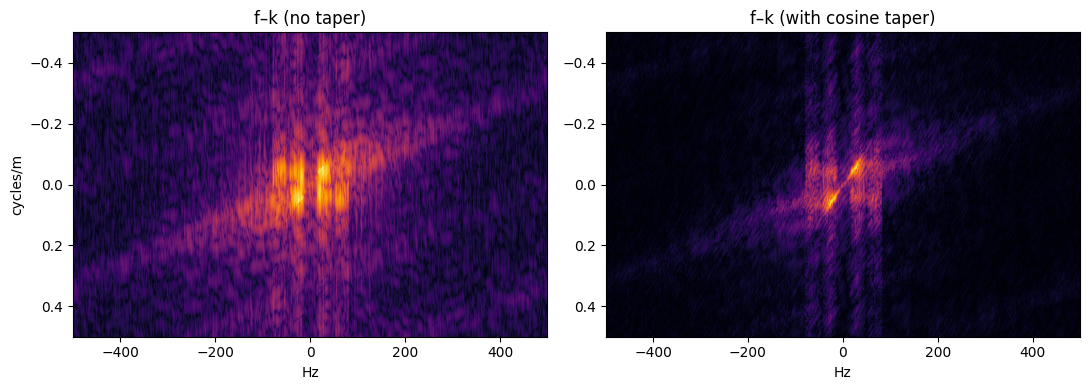

In [15]:
# BEFORE taper
G0   = upgoing_0
G0fk = np.fft.fft2(G0, axes=(0,1))
f0   = np.fft.fftfreq(G0.shape[1], d=dt)
k0   = np.fft.fftfreq(G0.shape[0], d=dz)

# AFTER taper (G_taper from Step 4.1)
Gtfk = np.fft.fft2(G_taper, axes=(0,1))
fsh, ksh = np.fft.fftshift(f0), np.fft.fftshift(k0)

import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.imshow(np.log1p(np.abs(np.fft.fftshift(G0fk))), aspect='auto',
           extent=[fsh[0], fsh[-1], ksh[-1], ksh[0]], cmap='inferno')
plt.title('f–k (no taper)'); plt.xlabel('Hz'); plt.ylabel('cycles/m')

plt.subplot(1,2,2)
plt.imshow(np.log1p(np.abs(np.fft.fftshift(Gtfk))), aspect='auto',
           extent=[fsh[0], fsh[-1], ksh[-1], ksh[0]], cmap='inferno')
plt.title('f–k (with cosine taper)'); plt.xlabel('Hz')
plt.tight_layout(); plt.show()


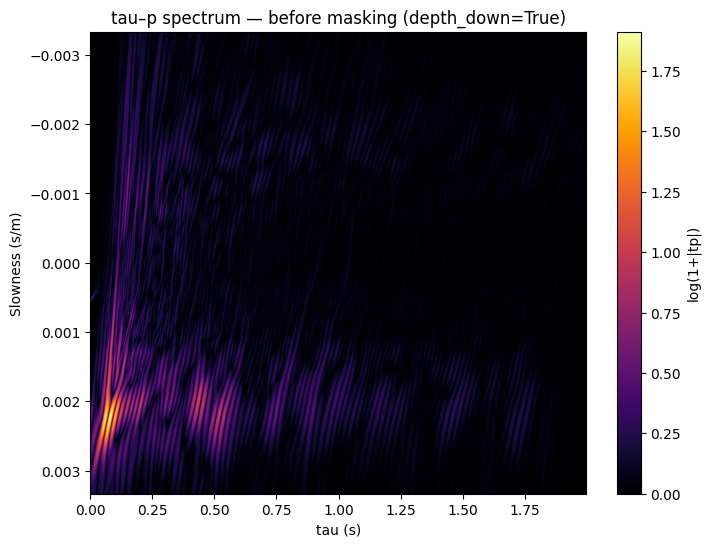

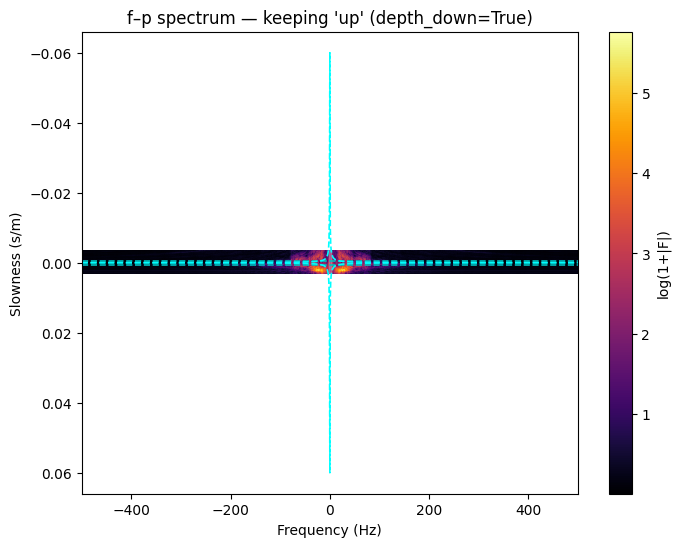

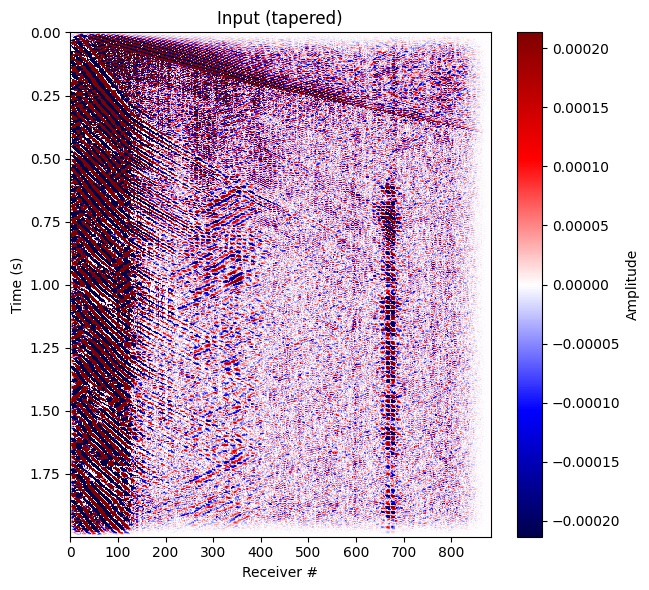

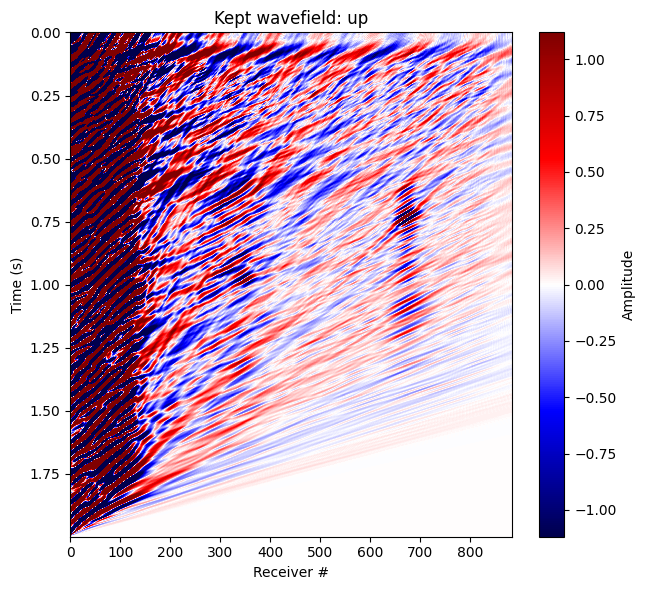

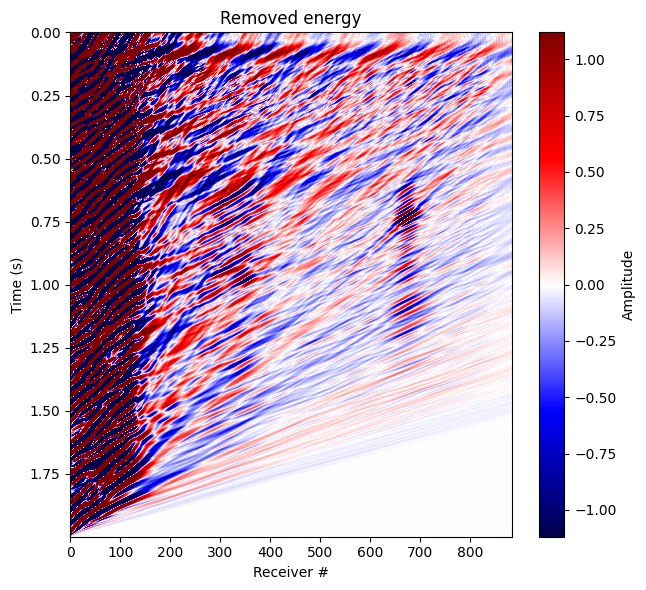

In [24]:
# ============================
# Step 4: tau-p separation (up vs down)
# ============================
import numpy as np
import matplotlib.pyplot as plt

def cosine_taper_1d(n, frac=0.1):
    frac = float(np.clip(frac, 0.0, 0.5)); m = int(frac*n)
    w = np.ones(n)
    if m>0:
        ramp = 0.5*(1 - np.cos(np.pi*np.arange(m)/m))
        w[:m]=ramp; w[-m:]=ramp[::-1]
    return w

def soft_keep_inside_cone(v_app, vcut, width):
    x = (vcut - v_app)/max(width,1e-12)
    x = np.clip(x, -1.0, 1.0)
    return 0.5*(1.0 + np.cos(np.pi*np.maximum(0.0, 1.0 - (x+1.0)/2.0)))

def tau_p_keep_direction(
    G, dt, dz,
    direction='up',              # 'up' or 'down'
    depth_positive_down=True,    # <-- set False if your receiver index increases upward
    v_app_max=1800.0, v_taper=400.0,
    v_app_min=300.0,
    lowcut_hz=2.0, k_notch=0.02,
    depth_taper=0.10, time_taper=0.05
):
    nr, nt = G.shape
    t = np.arange(nt) * dt

    # tapers
    taper_d = cosine_taper_1d(nr, depth_taper)
    taper_t = cosine_taper_1d(nt, time_taper)
    G_taper = G * taper_d[:, None] * taper_t[None, :]

    # define p range
    p_max = 1.0 / v_app_min
    num_p = int(1.5 * nr)
    if num_p % 2 == 0:
        num_p += 1
    p = np.linspace(-p_max, p_max, num_p)

    # forward tau-p (linear Radon transform)
    tp = np.zeros((len(p), nt))
    for ip, pp in enumerate(p):
        for ir in range(nr):
            shift = pp * (ir * dz)
            t_shifted = t + shift if depth_positive_down else t - shift
            idx_shifted = t_shifted / dt
            interp = np.interp(idx_shifted, np.arange(nt), G_taper[ir], left=0, right=0)
            tp[ip] += interp

    # plot in tau-p domain
    tau_shift = t
    p_shift = p
    plt.figure(figsize=(8,6))
    plt.imshow(np.log1p(np.abs(tp)), aspect='auto',
               extent=[tau_shift[0], tau_shift[-1], p_shift[-1], p_shift[0]],
               cmap='inferno')
    plt.title(f"tau–p spectrum — before masking (depth_down={depth_positive_down})")
    plt.xlabel("tau (s)"); plt.ylabel("Slowness (s/m)")
    plt.colorbar(label="log(1+|tp|)"); plt.show()

    # compute f-p spectrum for plotting (before masks)
    f = np.fft.fftfreq(nt, dt)
    tp_f = np.fft.fft(tp, axis=1)
    tp_f_shift = np.fft.fftshift(tp_f, axes=1)
    f_shift = np.fft.fftshift(f)
    p_shift = p
    plt.figure(figsize=(8,6))
    plt.imshow(np.log1p(np.abs(tp_f_shift)), aspect='auto',
               extent=[f_shift[0], f_shift[-1], p_shift[-1], p_shift[0]],
               cmap='inferno')
    # cone boundaries (horizontal)
    p_bound = 1.0 / v_app_max
    plt.axhline(p_bound, color='c', ls='--', lw=1.2)
    plt.axhline(-p_bound, color='c', ls='--', lw=1.2)
    # k_notch boundaries (hyperbolic)
    f_line = np.linspace(f_shift[0], f_shift[-1], 1200)
    f_abs = np.abs(f_line)
    f_abs[f_abs < 1e-6] = 1e-6
    p_line_pos = k_notch / f_abs
    p_line_neg = -p_line_pos
    plt.plot(f_line, p_line_pos, 'cyan', ls='--', lw=1.2)
    plt.plot(f_line, p_line_neg, 'cyan', ls='--', lw=1.2)
    # lowcut span
    plt.axvspan(-lowcut_hz, lowcut_hz, color='white', alpha=0.2)
    plt.title(f"f–p spectrum — keeping '{direction}' (depth_down={depth_positive_down})")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("Slowness (s/m)")
    plt.colorbar(label="log(1+|F|)"); plt.show()

    # direction mask
    if depth_positive_down:
        up_mask = (p < 0)
        down_mask = (p > 0)
    else:
        up_mask = (p > 0)
        down_mask = (p < 0)
    dir_mask = up_mask if direction == 'up' else down_mask

    # cone mask (slowness taper)
    p_abs = np.abs(p)
    v_app = np.zeros_like(p)
    eps = 1e-12
    v_app[p_abs > eps] = 1.0 / p_abs[p_abs > eps]
    cone = soft_keep_inside_cone(v_app, v_app_max, v_taper)

    # apply p-based masks
    mask_p = cone * dir_mask.astype(float)
    tp *= mask_p[:, None]

    # FFT along tau for frequency-based masks (re-fft after mask)
    tp_f = np.fft.fft(tp, axis=1)

    # lowcut mask
    lowf_mask = (np.abs(f) >= lowcut_hz)[None, :]

    # k_notch mask: keep if |f| * |p| >= k_notch
    knotch_mask = (np.abs(f)[None, :] * np.abs(p)[:, None] >= k_notch)

    # apply frequency masks
    tp_f *= lowf_mask
    tp_f *= knotch_mask

    # inverse FFT
    tp_keep = np.fft.ifft(tp_f, axis=1).real

    # inverse tau-p (adjoint)
    G_keep = np.zeros_like(G)
    for ip, pp in enumerate(p):
        for ir in range(nr):
            shift = pp * (ir * dz)
            t_shifted = t - shift if depth_positive_down else t + shift
            idx_shifted = t_shifted / dt
            interp = np.interp(idx_shifted, np.arange(nt), tp_keep[ip], left=0, right=0)
            G_keep[ir] += interp

    G_removed = G_taper - G_keep

    def show(D, title):
        vmax = np.percentile(np.abs(D), 85)
        plt.figure(figsize=(6.6,6))
        plt.pcolormesh(np.arange(nr), t, D.T, shading='nearest', cmap='seismic',
                       vmin=-vmax, vmax=vmax)
        plt.gca().invert_yaxis(); plt.colorbar(label="Amplitude")
        plt.xlabel("Receiver #"); plt.ylabel("Time (s)"); plt.title(title)
        plt.tight_layout(); plt.show()

    show(G_taper,  "Input (tapered)")
    show(G_keep,   f"Kept wavefield: {direction}")
    show(G_removed,"Removed energy")

    return G_keep, G_removed


# ============================
# Example run
# ============================
dt = 0.001; dz = 1.0

# Try with depth axis NOT positive down (flip convention)
G_up, _ = tau_p_keep_direction(
    upgoing_0, dt, dz,
    direction='up',
    depth_positive_down=True,   # <--- key change
    v_app_max=1800, v_taper=400,
    v_app_min=300,
    lowcut_hz=2, k_notch=0.01
)


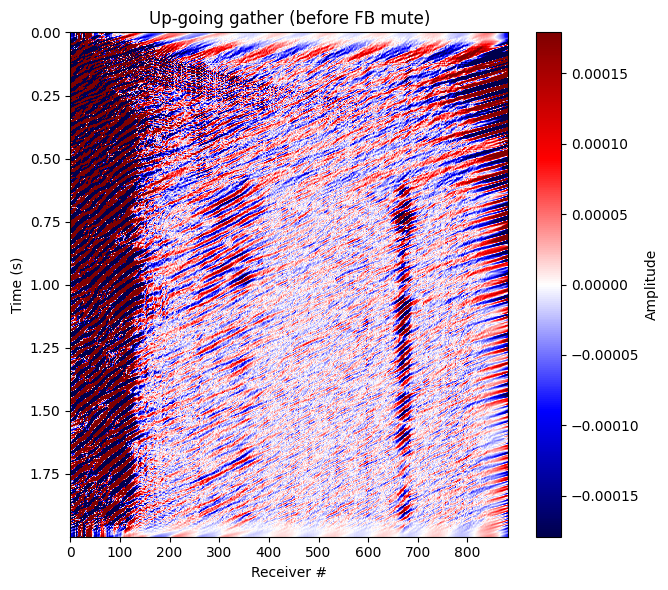

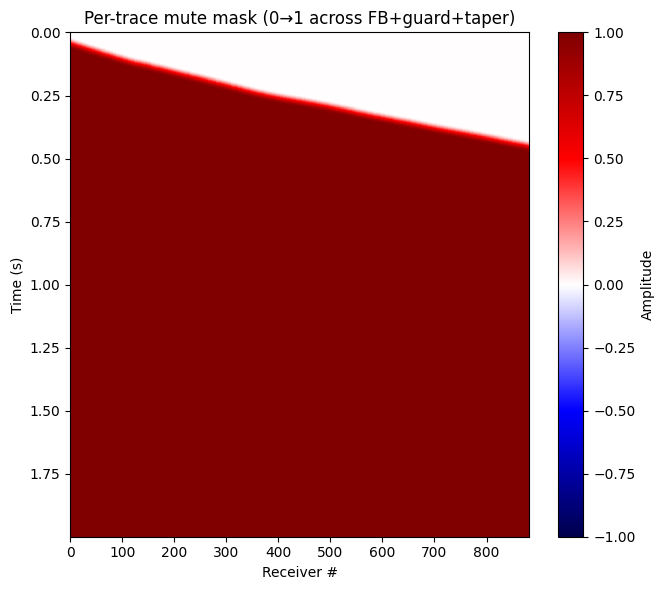

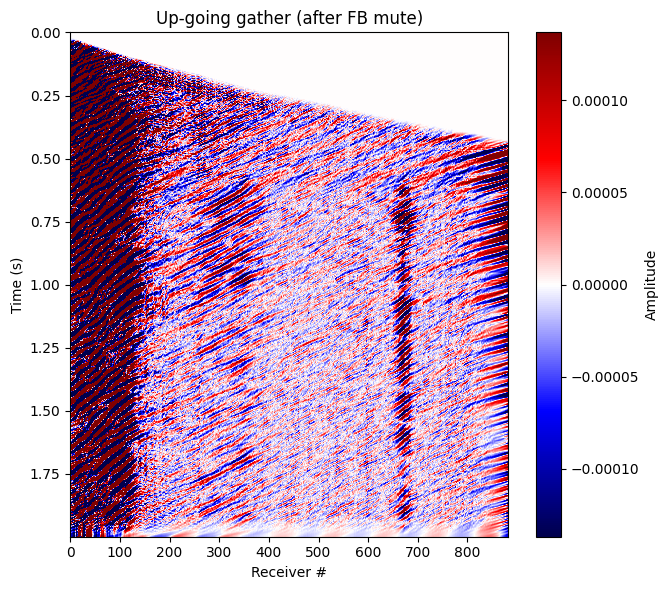

In [37]:
## Step 5 First Pick mute
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---- inputs ----
dt   = 0.001               # s
fb_csv = "real_first_picks.csv"  # two columns: trace, time(s)
nr, nt = G_up.shape
t = np.arange(nt) * dt
r = np.arange(nr)

# ---- load first-breaks (sec) and map to all receivers ----
df = pd.read_csv(fb_csv, header=None, names=["trace","time_s"])
fb_trace = df["trace"].to_numpy(dtype=int)
fb_time  = df["time_s"].to_numpy(float)

# safety: clamp to array bounds
fb_trace = np.clip(fb_trace, 0, nr-1)
# create per-trace fb by interpolation over available picks
fb_full = np.interp(r, fb_trace, fb_time)          # seconds
fb_idx  = np.clip((fb_full / dt).astype(int), 0, nt-1)

# ---- design a per-trace mute that keeps only AFTER first break ----
guard  = 0.020   # s  (extra delay after FB to be safe, e.g., 20 ms)
taper  = 0.050   # s  (cosine taper length, e.g., 50 ms)

guard_samp = int(round(guard / dt))
tap_samp   = max(1, int(round(taper / dt)))

M = np.zeros_like(G_up)   # mask: 0 before FB, 1 after FB+guard, cosine in-between

for i in range(nr):
    i0 = fb_idx[i] + guard_samp              # start of pass
    i1 = i0 + tap_samp                       # end of taper
    if i0 < nt:
        # linear index safety
        i1 = min(i1, nt)
        # cosine taper up
        if i0 > 0:
            w = 0.5*(1 - np.cos(np.pi * np.linspace(0, 1, i1 - i0, endpoint=False)))
            M[i, i0:i1] = w
        M[i, i1:] = 1.0

# ---- apply mute ----
G_up_muted = G_up * M

# ---- plots: before / mask / after ----
def show(G, title):
    vmax = np.percentile(np.abs(G), 85)
    plt.figure(figsize=(6.8,6))
    plt.pcolormesh(r, t, G.T, shading='nearest', cmap='seismic',
                   vmin=-vmax, vmax=vmax)
    plt.gca().invert_yaxis()
    plt.xlabel("Receiver #"); plt.ylabel("Time (s)")
    plt.colorbar(label="Amplitude")
    plt.title(title); plt.tight_layout(); plt.show()

show(G_up,        "Up-going gather (before FB mute)")
show(M,           "Per-trace mute mask (0→1 across FB+guard+taper)")
show(G_up_muted,  "Up-going gather (after FB mute)")




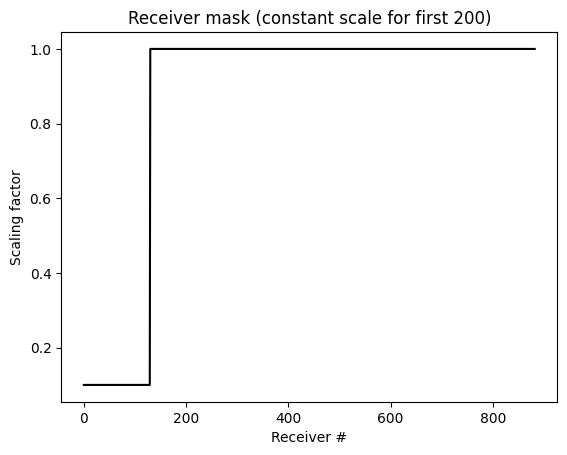

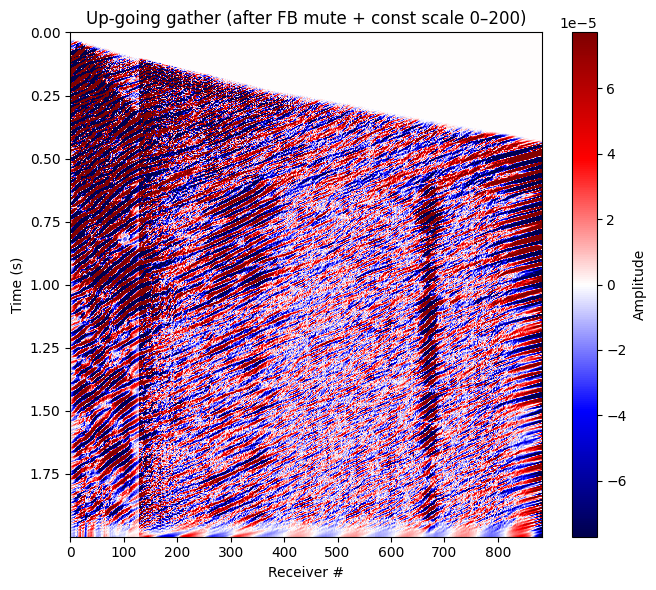

In [39]:
# ============================
# Step 6: Constant scaling for first 200 receivers
# ============================

def scale_first_receivers(G, n_const=130, scale=0.1):
    """
    Apply a constant amplitude scaling to the first n_const receivers.
    After n_const, amplitudes are unchanged (scale = 1).
    """
    nr, nt = G.shape
    mask = np.ones(nr)
    mask[:n_const] = scale
    return G * mask[:, None], mask

# Example: scale first 200 receivers by 0.2
G_up_scaled, mask = scale_first_receivers(G_up_muted, n_const=130, scale=0.1)

# QC plot mask
import matplotlib.pyplot as plt
plt.figure()
plt.plot(mask, 'k-')
plt.title("Receiver mask (constant scale for first 200)")
plt.xlabel("Receiver #")
plt.ylabel("Scaling factor")
plt.show()

# QC plot scaled gather
show(G_up_scaled, "Up-going gather (after FB mute + const scale 0–200)")


In [40]:
# import numpy as np

# # assume G_up_muted is your up-going, FB-muted gather (nr x nt)
# rtm_input = G_up_scaled.astype(np.float32, copy=False)

# # save as binary (row-major: receiver-fast, then time samples)
# rtm_input.tofile("rtm_input_upgoing_FB_neartrace.bin")

